# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

# Report

## Data loading and validation

   The csv file was imported using pandas, due to the library built in methods for data cleaning and analysis. Using the 'data.head()' method and 'data.dtypes' attribute, it was observed that the data provided contains missing values and that the data type in the 'servings' are diferent from those provided in the document.

    Checking the columns to see how many missing values, it was observed that calories, carbohydrate, sugar, and protein all have 52 missing values, while the high_traffic has 373.

    Filtering the dataframe to show only rows where the any value in the columns with 52 missing values where missing, it showed that all nutritional info in these recipes where missing, calculating the total amount of missing values in proportion to the total dataset equals to ≃5,5% and seeing that there was no other way to recover that information, the rows where dropped. 

    Regarding the 'high_traffic' column, the document specified that the recipes that generated high traffic where labeled as "High", while all others are 'NaN', the method to deal with it was the '.fillna()' method, by replacing 'NaN' with 'Low'.

    To check the data format and integrity the following datasheet provided in the document was used as reference:

| Column Name | Details |
| :---: | :---: |
|recipe | Numeric, unique identifier of recipe |
| calories | Numeric, number of calories |
| carbohydrates | Numeric. amount of carbohydrates in grams |
| sugar | Numeric, amount of sugar in grams |
| protein | Numeric, amount of proteins in grams |
| category | Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal').|
| servings | Numeric, number of servings for the recipe |
| high_traffic | Character,  if the traffic to the site was high when this recipe was shown, this is marked with “High”.|

The following methods where used to confirm the data integrity:

     'recipe' column was checked to see if each recipe number was unique. it was correct

     'category' used the '.unique()' method to view all unique entries, there was a category different to those specified in the datasheet, 'Chicken Breast', it was assumed as the 'Chicken' category an its values where replaced using the '.replace()' method

     'servings' used the '.unique()' method to view all unique entries, some entries had extra descriptors to the serving size like '4 as a snack', the '.replace()' method was used with a dictionary to replace the entries

     'high_traffic' also used the '.unique()' method, and the printed values where correct

     Finaly a data type dictionary was created according to the datasheet and the types where assigned using the '.astype()' method

## Exploratory Analysis

    Initially the '.describe()' method was used to show some summary statistics, observing the results, it seems that the results are all positive and within realistic expectations, but the calories, carbohydrate, sugar and protein columns all have a very high range of values with orders of magnitude higher, like the 'calories' goes from 0.14 to 3633.16.

    Using seaborn and matplotlib to visualize the distributions we can see that most values in these columns are on the lower side, and showing that values in the higer quantiles are rare.
    The site contains 10 categories of recipes with the majority being 'Chicken' and the least being 'One Dish Meal' the variety is very large, but it is concentrated in one category

    Ploting the count of popular recipes per categories, the 'Chicken' category isn't the most popular, despite being the most prevalent, that title goes to the 'Potato' category with ≃ 94% of recipes generating high traffic, and proportionaly the category with the most popular recipes is the 'Vegetable' with ≃ 98,7% of its recipes generating high traffic

    Creating a heat map of the nutritional values protein, sugar, carbohydrates and calories, show that there is no significant correlation between these values.

    Checking the distribution of the nutritional values divided into 'High' and 'Low' traffic, only the 'sugar' value looses traffic with increase in value while the others behave in the oposite way.

## Model Development

    The request from the client is to predict wich recipes will generate High traffic, with this the model to be developed is a classification model. Based on these four models of classifiers where chosen.
    -   RandomForestClassifier, Good for handling complex relationships and  robust to overfitting
    -   GradientBoostingClassifier, Good for coomplex relationships and handling of outliers
    -   KNeighborsClassifier, non parametric, capture complex decison boundaries and good for the smaller dataset
    -   LogisticRegression, simple and easy to capture the impact of each feature and efficient

    The data was processed to model fitting by, one hot encoding the 'category' column, using the 'LabelBinarizer' function to transform the target variable 'high_traffic', the features 'calories', 'carbohydrate', 'sugar' and 'protein' where processed with the 'Normalizer' scaler. The data was split into training and testing sets with the testing set being 20% of the total data.

    After a testing run to check the performance of the models, the best performing was the 'LogisticRegression'and the second best was the 'RandomForestClassifier'. for finetuning the models a 'RandomizedSearchCV' was used to choose the best parameters.

## Model Evaluation

    The final 'LogisticRegression' model accuracy was ≃ 77,00%. Close to the requested 80% by the client.
    Using the 'classification_report' function it shows a precision of ≃ 77,00% and a recall score of ≃ 77,00%, showing that it is good in identifying true cases of high traffic reipes

    For the 'RandomForestClassifier' the accuracy was ≃ 71,00%, below the performance of the 'LogisticRegression' model.
    Using the 'classification_report' function it shows a precision of ≃ 71,00% and a recall score of ≃ 70,00%, having a worse performance compared to the previous model.

    Both models have a significant performance improvment compared to a model assigning only high or low to all the recipes wich wold be around 59% and 40% respectively

    Based on these scores the model better suited for the business is the 'LogisticRegression' model.

## Business Metrics

    Based on the business goals of predicting high traffic recipes and predict a 'High' value for the recipes with 80% propability. 
    The model performs well in selecting true cases of 'high' popularity recipes, in doing so it will increase consistency of the average site traffic and the amount of subscriptions as well. It being compared to a random selection of recipes that according to the data has a probability of around 59% of increasing the traffic, the model has an increase of 17% in this performance, where each percent is significant.

    Also i recomend to eep track of the recall value, this will indicate if the model is correctly recomending true cases of popular recipes, watch time spent on page, this will show if the recipes are engaging the user well, page traffic, see if the recomendation system is increasing the site traffic.
    In terms of business impact, the implementation of the model is expected to lead to improvements in engagement metrics such as time on page and subscription rate. A conservative estimate could be a 10-20% increase in these metrics over the baseline.


## Final Summary

    My recommendation to the busines is to compare the real performance of the model implementation a A/B test would be ideal for such case, by using the 'A' control group without the model  and the 'B' group that will recive model recomendations. 
    The values to observe should be the time on page wich should indicate that the recipe has the atention of the target, the amount of users that subscribe to the site and overall traffic of the pages since the more apealing version will tend to generate a organic growth to the site.

    About the data provided, there where some recipes without any nutritional values marked as 'high' traffic, i would recomend a more detailed look into it, since it could mean that some recipes being shown are empty pages.
    Also observing the 'category' data there are a lot of 'chicken' recipes, and most of them aren't very popular, so focusing on other categories like 'Potato', 'Vegetable' and 'Pork' recipes should have an inpact in the amount of popular recipes since the proportion of 'High' traffic recipes in these categories is greater than 90%
    regarding the information in the dataset, a more complete set of variables would make a more accurate analysis and likely a better performing model, information such as ingredients, if the recipes contains alergenics and the cooking time seems likely to influence the users in the choice of a recipe.
    A final recomendation would be a change in the 'category' data, some of the current categories are more appropiate for a 'main_ingredient' column, more adequate values in the 'category' column would be party, group, casual, quick, snack and so on. Since filtering a search by these values would be more convenient for users, shown that the categories are very influential in the model coeficients.

# Data loading and validation

In [31]:
# Load libraries for data wrangling
import pandas as pd

# Load Data
data = pd.read_csv('data/'+'recipe_site_traffic_2212.csv')

# Inspect the data head and columns data types
display(data.head(), data.dtypes)

# Check the ammount of null values
print(data.isna().sum())

# Select the columns with null values and inspect the missing values
display(data[data.isna().any(axis=1)])

# Inspect the 'calories', 'carbohydrate', 'sugar' and 'protein' columns
display(data[data[['calories', 'carbohydrate', 'sugar', 'protein']].isna().any(axis=1)])

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
6,7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN
...,...,...,...,...,...,...,...,...
939,940,2283.29,34.34,5.12,17.57,Chicken Breast,6,NaN
940,941,1337.50,49.91,0.76,57.90,Chicken,4,NaN
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,NaN
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,NaN
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken Breast,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


Observing the missing values for the calories, carbohydrate, sugar and protein values appear in all the columns, and assuming that the data couldn't be recovered by the product manager from the recipe discovery the missing entries will be removed, since the ammount of missing entries is about ≃ 5,5%, removing the data shouldn't cause problems with the analysis and model development


In [32]:
# Drop the missing entries from the subset of columns
data.dropna(subset=['calories','carbohydrate', 'sugar', 'protein'], inplace=True)

# Check again the misisng values
print(data.isna().sum())

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    360
dtype: int64


After removing the missing entries in the data, the column to observe is the 'high_traffic' values, remembering that the customer states in the document that the recipe was marked 'High' if the recipe was shown, the missing values will be replaced with 'Low'.

In [33]:
# Fill missing values with 'Low'
data.high_traffic.fillna(value='Low', inplace=True)

# Check the resulting data
display(data.isna().sum(), data.head())

/tmp/ipykernel_2197406/1338169399.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.high_traffic.fillna(value='Low', inplace=True)


recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High


With the missing values treated, next the data integrity will be checked. Following the format specified in the provided documment

| Column Name | Details |
| :---: | :---: |
|recipe | Numeric, unique identifier of recipe |
| calories | Numeric, number of calories |
| carbohydrates | Numeric. amount of carbohydrates in grams |
| sugar | Numeric, amount of sugar in grams |
| protein | Numeric, amount of proteins in grams |
| category | Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal').|
| servings | Numeric, number of servings for the recipe |
| high_traffic | Character,  if the traffic to the site was high when this recipe was shown, this is marked with “High”.|


In [34]:
# Check if the recipe column is made of unique entries
print(data.recipe.nunique() == data.shape[0])

# Check if the values in the category column match with those specified in the document
print(data.category.unique())

# Check the values of the 'servings' columns, since it is loaded as 'object' but should be a numeric value
print(data.servings.unique())

# Confirm if the values of 'high_traffic' are only 'High' and 'Low'
print(data.high_traffic.unique())

True
['Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Pork' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
['4' '1' '2' '6' '4 as a snack' '6 as a snack']
['High' 'Low']


The columns 'category' and 'servings' contains different values from those specified in the document, they will be replaced to match the document and the dtype of the 'servings' column will be converted to 'int' after the treatment

In [35]:
# The value 'Chicken Breast' does not appear in the specified values
# it will be assumed that it fits in the 'Chicken' category and replaced
data.category.replace(to_replace='Chicken Breast', value='Chicken', inplace=True)

# Servings contains some descriptions for the '4 as a snack' and '6 as a snack'
values = {'4 as a snack':'4' , '6 as a snack':'6'}
data.replace(values, inplace=True)

/tmp/ipykernel_2197406/2732093481.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.category.replace(to_replace='Chicken Breast', value='Chicken', inplace=True)


In [36]:
# Check the corrected values
display(data.category.unique(), data.servings.unique())

array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken',
       'Lunch/Snacks', 'Pork', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

array(['4', '1', '2', '6'], dtype=object)

In [37]:
# Fix the data type of the final columns
data_types = {
    'recipe':'int',
    'calories':'float',
    'carbohydrate':'float',
    'sugar':'float',
    'protein':'float',
    'category':'object',
    'servings':'int',
    'high_traffic':'object'
}
# Convert the dtypes to the document specifications
data = data.astype(dtype=data_types)

# inspect data
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        895 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      895 non-null    object 
 6   servings      895 non-null    int64  
 7   high_traffic  895 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 62.9+ KB


None

# Data Exploration

In [38]:
# Check summary statistics
display(data.describe())

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


In [39]:
# import libraries to data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set the dark background style and dark color palette
#custom = {'axes.edgecolor': 'black', 'axes.facecolor': '#292929', 'axes.abelcolor': '.15', 'grid.color': 'black', 'text.color': '1', 'xtick.color': '.5', 'ytick.color': '.15'}
sns.set_style('darkgrid')
#palette = ['#7b6079', '#fea82f']
#sns.set_palette(palette=palette)

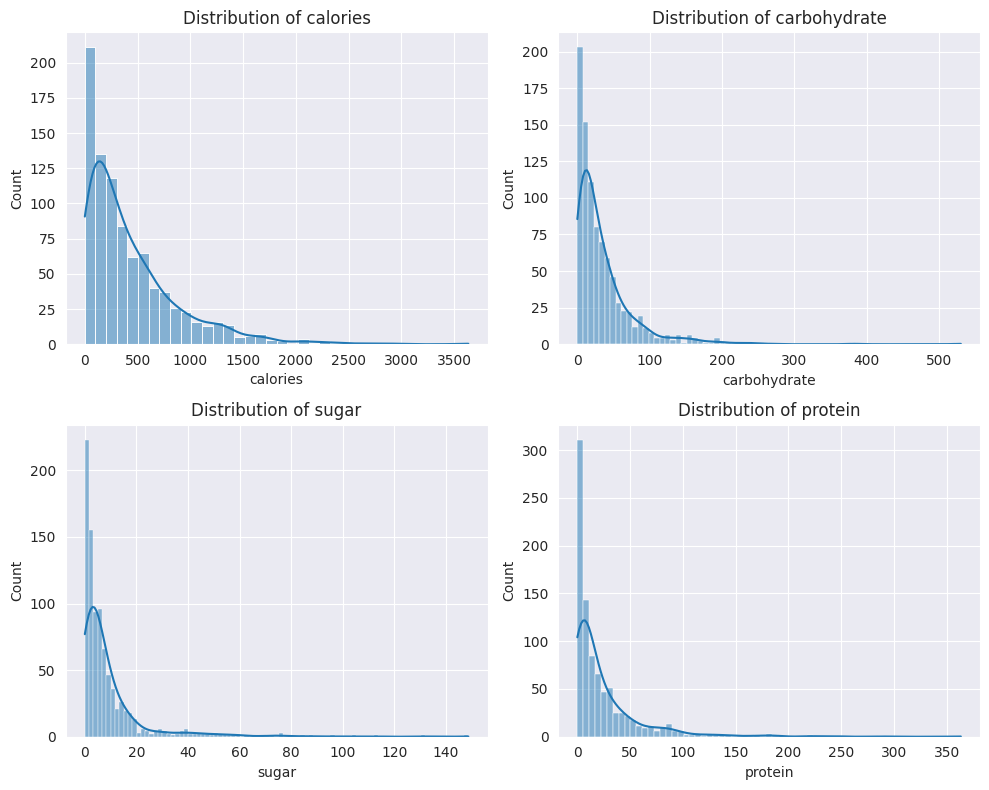

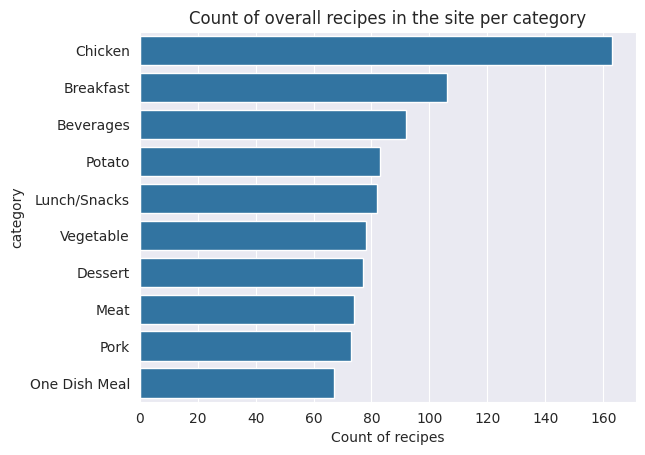

In [40]:
# View distribution of values in columns
viz_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
# Create a figure with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(viz_columns):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Check the categories with most recipes
sorted_order = data['category'].value_counts().index
sns.countplot(data=data, y='category', order=sorted_order)
plt.title('Count of overall recipes in the site per category')
plt.xlabel('Count of recipes')
plt.show()


/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


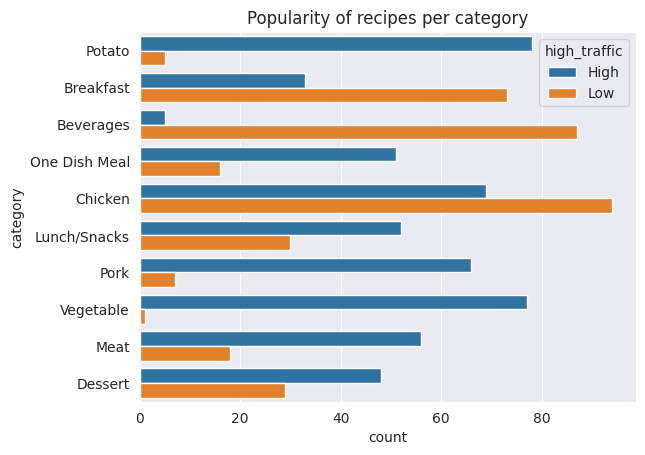

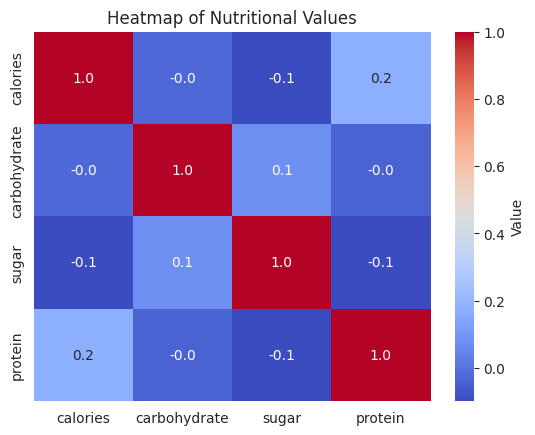

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


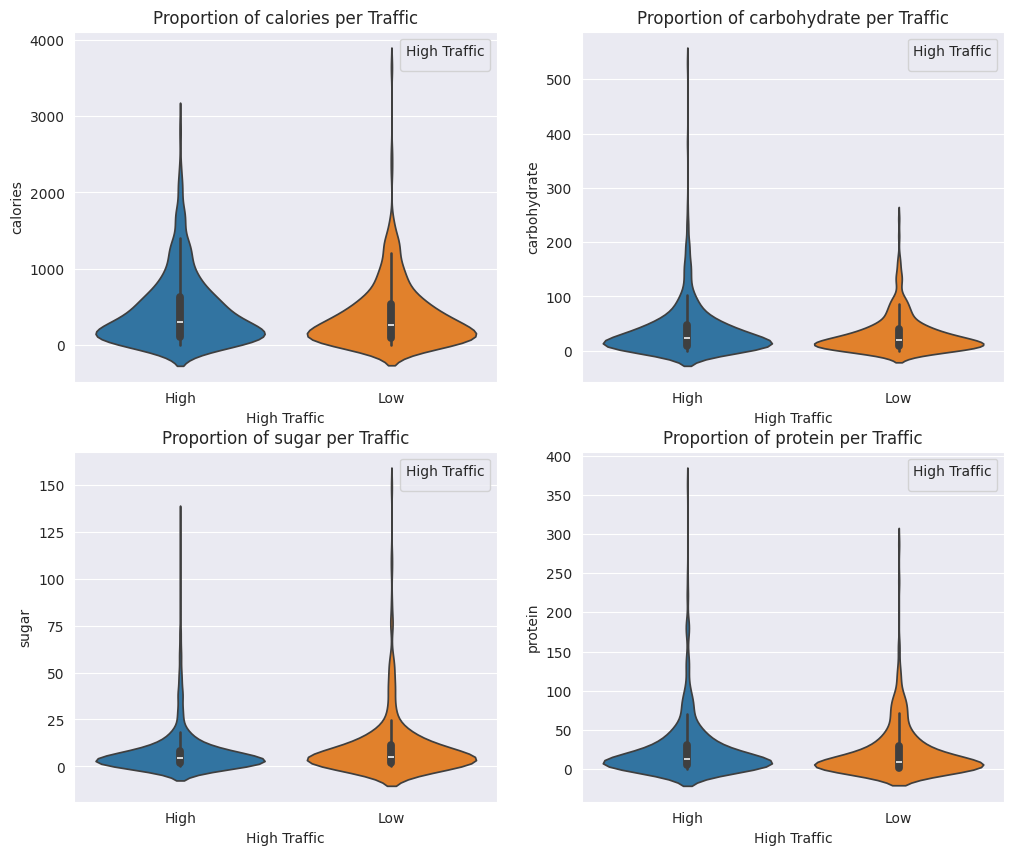

In [41]:
# Check the most popular categories
sns.countplot(data=data, y='category', hue='high_traffic')
plt.title('Popularity of recipes per category')
plt.show()

# Check the correlation of the nutritional data
heatmap = sns.heatmap(data=data[viz_columns].corr(), annot=True, cmap='coolwarm', fmt='.1f', cbar_kws={'label': 'Value'})
plt.title('Heatmap of Nutritional Values')
plt.show()

# Check the distribution of values per category and popularity
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Loop through each variable in the list and create a violin plot
for i, col in enumerate(viz_columns):
    sns.violinplot(data=data, y=col, x='high_traffic', hue='high_traffic', ax=axes[i])
    axes[i].set_title(f'Proportion of {col} per Traffic')
    axes[i].set_xlabel('High Traffic')
    axes[i].set_ylabel(col)
    axes[i].legend(title='High Traffic')


In [42]:
# proportion of popularity of each category
cats = data.category.unique()
for cat in cats:
    print('\n',cat,':\n',data[data['category'] == cat].high_traffic.value_counts(normalize=False), '\n',end=40*'=')


 Potato :
 high_traffic
High    78
Low      5
Name: count, dtype: int64 
 Breakfast :
 high_traffic
Low     73
High    33
Name: count, dtype: int64 
 Beverages :
 high_traffic
Low     87
High     5
Name: count, dtype: int64 
 One Dish Meal :
 high_traffic
High    51
Low     16
Name: count, dtype: int64 
 Chicken :
 high_traffic
Low     94
High    69
Name: count, dtype: int64 
 Lunch/Snacks :
 high_traffic
High    52
Low     30
Name: count, dtype: int64 
 Pork :
 high_traffic
High    66
Low      7
Name: count, dtype: int64 
 Vegetable :
 high_traffic
High    77
Low      1
Name: count, dtype: int64 
 Meat :
 high_traffic
High    56
Low     18
Name: count, dtype: int64 
 Dessert :
 high_traffic
High    48
Low     29
Name: count, dtype: int64 

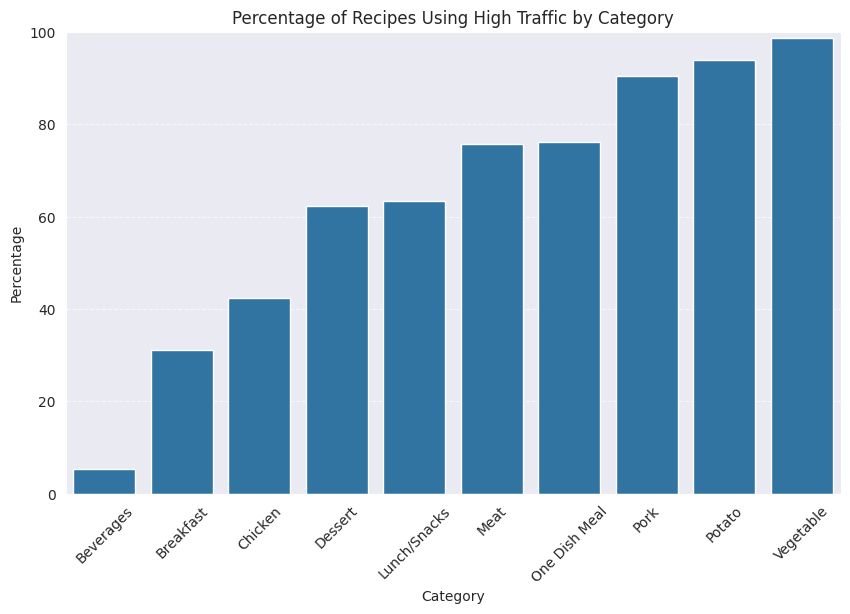

In [56]:
# Set seaborn style to darkgrid
sns.set_style("darkgrid")

# Replace 'High' with 1 and 'Low' with 0 in the 'high_traffic' column
perc_data = data.copy()
perc_data['high_traffic'] = perc_data['high_traffic'].map({'High': 1, 'Low': 0})

# Calculate the percentage of recipes using 'high_traffic' divided by 'category'
percentage_df = (perc_data.groupby('category')['high_traffic'].mean() * 100).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='high_traffic', data=percentage_df)
plt.title('Percentage of Recipes Using High Traffic by Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.ylim(0, 100)  # Set y-axis limit to 0-100 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()


# Model Development

In [44]:
# import libraries for model development
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, precision_score, accuracy_score # General classifier scores
from sklearn.preprocessing import Normalizer, OneHotEncoder, LabelBinarizer # Scaler and encoders
from sklearn.ensemble import RandomForestClassifier # baseline model
from sklearn.ensemble import GradientBoostingClassifier # comparison model 1
from sklearn.neighbors import KNeighborsClassifier # comparison model 2
from sklearn.linear_model import LogisticRegression # comparison model 3  
import numpy as np

In [45]:
# instanciate encoder
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(data[['category']])
categories = encoder.get_feature_names_out(['category'])

# instanciate binarizer
lbb = LabelBinarizer()

# Split the data into features and target
X = data.iloc[:, 1:-3]
X[categories] = encoded_data
y = lbb.fit_transform(data.iloc[:,-1])
y = y.ravel()

# Check shape of X and y
print(X.shape, y.shape)

# Split data into train and test
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state=42)

# Scale the data
scaler = Normalizer()
scaler.fit(X_train.iloc[:,0:4])
X_train.iloc[:,0:4] = scaler.fit_transform(X_train.iloc[:,0:4])
X_test.iloc[:,0:4] = scaler.fit_transform(X_test.iloc[:,0:4])

# Instanciate models
rfc = RandomForestClassifier()
knc = KNeighborsClassifier()
lrc = LogisticRegression()
gbc = GradientBoostingClassifier()

# Fit the models to the training data
rfc.fit(X_train, y_train)
knc.fit(X_train, y_train)
lrc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

# store the predictions
rfc_pred = rfc.predict(X_test)
knc_pred = knc.predict(X_test)
lrc_pred = lrc.predict(X_test)
gbc_pred = gbc.predict(X_test)

(895, 14) (895,)


/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
# Calculate scores
rfc_scores = {'accuracy' : accuracy_score(y_test, rfc_pred), 'precision' : precision_score(y_test, rfc_pred), 'class_report':classification_report(y_test, rfc_pred)}
knc_scores = {'accuracy' : accuracy_score(y_test, knc_pred), 'precision' : precision_score(y_test, knc_pred), 'class_report':classification_report(y_test, knc_pred)}
lrc_scores = {'accuracy' : accuracy_score(y_test, lrc_pred), 'precision' : precision_score(y_test, lrc_pred), 'class_report':classification_report(y_test, lrc_pred)}
gbc_scores = {'accuracy' : accuracy_score(y_test, gbc_pred), 'precision' : precision_score(y_test, gbc_pred), 'class_report':classification_report(y_test, gbc_pred)}

# Print scores
score_list = [('random forest',rfc_scores), ('K-Nearest',knc_scores), ('Logistic Regression',lrc_scores), ('Gradient boost',gbc_scores)]
for score in score_list:
    for key in score[1].keys():
        print(f'{score[0]}:\n{key}: {score[1][key]}')
# print(f'Random forest scores {rfc_scores}\n')


random forest:
accuracy: 0.6983240223463687
random forest:
precision: 0.6461538461538462
random forest:
class_report:               precision    recall  f1-score   support

           0       0.73      0.78      0.75       106
           1       0.65      0.58      0.61        73

    accuracy                           0.70       179
   macro avg       0.69      0.68      0.68       179
weighted avg       0.69      0.70      0.70       179

K-Nearest:
accuracy: 0.6983240223463687
K-Nearest:
precision: 0.6610169491525424
K-Nearest:
class_report:               precision    recall  f1-score   support

           0       0.72      0.81      0.76       106
           1       0.66      0.53      0.59        73

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.68       179
weighted avg       0.69      0.70      0.69       179

Logistic Regression:
accuracy: 0.770949720670391
Logistic Regression:
precision: 0.7285714285714285
Logistic Regression:
c

In [47]:
# create param distributions for the best performing model
param_dist_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': np.arange(50, 500, 50),  
    'random_state': [42]  
}


# Finetune the models
# Logistic Regression
lrc = LogisticRegression()
lr_rs = RandomizedSearchCV(lrc, param_distributions=param_dist_lr, n_iter=50, scoring='accuracy', cv=10, verbose=1, random_state=42)
lr_rs.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_iter=50,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'random_state': [42],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy', verbose=1)

In [48]:
# create param distributions for the best performing model
param_dist_rf = {
    'n_estimators': np.arange(50, 200, 10),  
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None] + list(np.arange(10, 110, 10)),  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'bootstrap': [True, False],  
    'random_state': [42]  
}


# Finetune the models
# Logistic Regression
rfc = RandomForestClassifier()
rfc_rs = RandomizedSearchCV(rfc, param_distributions=param_dist_rf, n_iter=50, scoring='accuracy', cv=10, verbose=1, random_state=42, n_jobs=-1)
rfc_rs.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
130 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190]),
                                        'random_state': [42]},
                   random_state=42, scoring='accuracy', verbose=1)

# Model Evaluation

In [49]:
# Calculate scores logistic regression
lr_rs_preds = lr_rs.predict(X_test)
lr_rs_scores = {'accuracy' : accuracy_score(y_test, lr_rs_preds), 'precision' : precision_score(y_test, lr_rs_preds), 'class_report':classification_report(y_test, lr_rs_preds)}

for key in lr_rs_scores.keys():
    print(f'{key} {lr_rs_scores[key]}')

accuracy 0.770949720670391
precision 0.7285714285714285
class_report               precision    recall  f1-score   support

           0       0.80      0.82      0.81       106
           1       0.73      0.70      0.71        73

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



In [50]:
# Calculate scores random forest classifier
rfc_rs_preds = rfc_rs.predict(X_test)
rfc_rs_scores = {'accuracy' : accuracy_score(y_test, rfc_rs_preds), 'precision' : precision_score(y_test, rfc_rs_preds), 'class_report':classification_report(y_test, rfc_rs_preds)}

for key in rfc_rs_scores.keys():
    print(f'{key} {rfc_rs_scores[key]}')

accuracy 0.7039106145251397
precision 0.6923076923076923
class_report               precision    recall  f1-score   support

           0       0.71      0.85      0.77       106
           1       0.69      0.49      0.58        73

    accuracy                           0.70       179
   macro avg       0.70      0.67      0.67       179
weighted avg       0.70      0.70      0.69       179



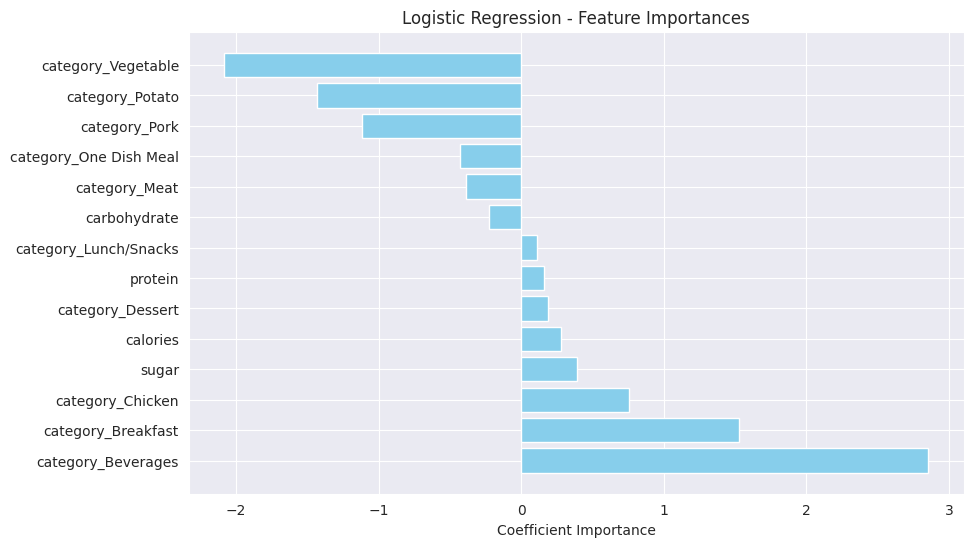

In [51]:
# plot the feature importances
columns = X_train.columns.to_list()
importances = lr_rs.best_estimator_.coef_[0]
feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': importances})

# Sort the dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Coefficient Importance')
plt.title('Logistic Regression - Feature Importances')
plt.show()



# Business

In [52]:
# predict the most popular recipes from the dataset
X_new = pd.concat([X_train,X_test]).sort_index()
X_new['popularity'] = lr_rs.predict_proba(X_new)[:,1]

# get the recipes with the highest scores of being popular
X_new_sorted = X_new.sort_values(by='popularity', ascending=False)
highest_indices = X_new_sorted.index
selected_data = data.loc[highest_indices, ['recipe','category']]
selected_X_new = X_new.loc[highest_indices, ['popularity']]
result_df = pd.concat([selected_X_new, selected_data], axis=1)

print(result_df)

     popularity  recipe   category
916    0.912863     917  Beverages
533    0.911224     534  Beverages
288    0.909097     289  Beverages
207    0.908582     208  Beverages
140    0.906927     141  Beverages
..          ...     ...        ...
832    0.043617     833  Vegetable
691    0.042450     692  Vegetable
825    0.041227     826  Vegetable
820    0.040384     821  Vegetable
837    0.040325     838  Vegetable

[895 rows x 3 columns]


     popularity  recipe   category
916    0.912863     917  Beverages
533    0.911224     534  Beverages
288    0.909097     289  Beverages
207    0.908582     208  Beverages
140    0.906927     141  Beverages
..          ...     ...        ...
791    0.869074     792  Beverages
680    0.862157     681  Beverages
652    0.858611     653  Beverages
500    0.858001     501  Beverages
387    0.846087     388  Beverages

[92 rows x 3 columns]
category
Beverages    1.0
Name: proportion, dtype: float64


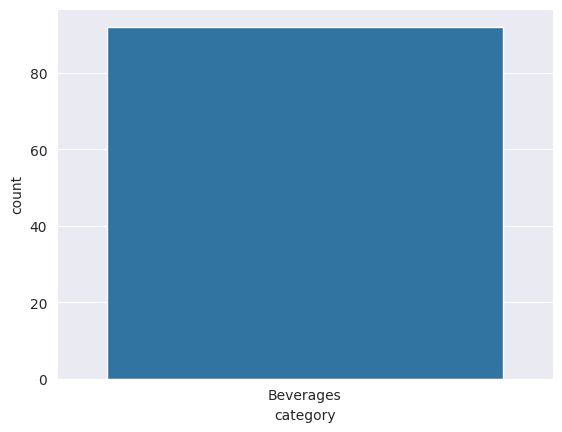

In [53]:
# Recipes with more than 80% certantly of high popularity
high_pop_recipes = result_df[result_df.popularity >= 0.50]
print(high_pop_recipes)
print(high_pop_recipes.category.value_counts(normalize=True))
# Show show category counts
sns.countplot(data=high_pop_recipes, x='category')
plt.show()

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation